In [1]:
import os

In [2]:
import re
import time
import pandas as pd
import xarray as xr
from numpy import ones
from numpy.linalg import cholesky
from pandas_plink import read_plink1_bin
from limix.qc import quantile_gaussianize

from cellregmap import CellRegMap, run_interaction

In [3]:
i = 2
seed = 0

In [4]:
revision_folder = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/"

####### right away check if this was already run for this gene
# filter file (columns: snp_id, gene)
fvf_filename = revision_folder+"/CRM_interaction_chr22/fvf.csv"
fvf = pd.read_csv(fvf_filename, index_col = 0)
print(fvf.head())

                feature            snpID  chrom
1  ENSG00000100206_DMC1  22_38815543_G_T     22
2  ENSG00000100206_DMC1  22_38815767_C_T     22
3  ENSG00000100206_DMC1  22_38816059_T_C     22
4  ENSG00000100206_DMC1  22_38816351_G_A     22
5  ENSG00000100206_DMC1  22_38817047_A_G     22


In [5]:
genes = fvf['feature'].unique()
print(genes)

['ENSG00000100206_DMC1' 'ENSG00000182858_ALG12' 'ENSG00000100243_CYB5R3'
 'ENSG00000099974_DDTL' 'ENSG00000128340_RAC2' 'ENSG00000240972_MIF'
 'ENSG00000100034_PPM1F' 'ENSG00000130638_ATXN10' 'ENSG00000198355_PIM3'
 'ENSG00000099904_ZDHHC8' 'ENSG00000100029_PES1' 'ENSG00000133466_C1QTNF6'
 'ENSG00000186716_BCR' 'ENSG00000100263_RHBDD3' 'ENSG00000099889_ARVCF'
 'ENSG00000100151_PICK1' 'ENSG00000099949_LZTR1' 'ENSG00000184674_GSTT1'
 'ENSG00000099958_DERL3' 'ENSG00000099977_DDT' 'ENSG00000185252_ZNF74'
 'ENSG00000100014_SPECC1L' 'ENSG00000128191_DGCR8'
 'ENSG00000100350_FOXRED2' 'ENSG00000239713_APOBEC3G'
 'ENSG00000128309_MPST' 'ENSG00000100099_HPS4' 'ENSG00000100033_PRODH'
 'ENSG00000188130_MAPK12' 'ENSG00000184164_CRELD2' 'ENSG00000100410_PHF5A'
 'ENSG00000100056_DGCR14' 'ENSG00000100354_TNRC6B'
 'ENSG00000205853_RFPL3S' 'ENSG00000100225_FBXO7' 'ENSG00000015475_BID'
 'ENSG00000100196_KDELR3' 'ENSG00000128311_TST' 'ENSG00000100083_GGA1'
 'ENSG00000184208_C22orf46' 'ENSG00000069998_CECR

In [6]:
gene_name = genes[i]
trait_name = re.sub("_.*","",gene_name)
print(gene_name)
print(trait_name)

ENSG00000100243_CYB5R3
ENSG00000100243


In [7]:
fvf_gene = fvf[fvf['feature']==gene_name]
fvf_gene

,feature,snpID,chrom
735,ENSG00000100243_CYB5R3,22_42914931_T_C,22
736,ENSG00000100243_CYB5R3,22_42914937_A_G,22
737,ENSG00000100243_CYB5R3,22_42914974_T_C,22
738,ENSG00000100243_CYB5R3,22_42915479_G_A,22
739,ENSG00000100243_CYB5R3,22_42916215_C_G,22
...,...,...,...
1416,ENSG00000100243_CYB5R3,22_43144054_G_C,22
1417,ENSG00000100243_CYB5R3,22_43144502_A_G,22
1418,ENSG00000100243_CYB5R3,22_43144771_G_C,22
1419,ENSG00000100243_CYB5R3,22_43145421_G_C,22


In [8]:
n = fvf_gene.shape[0]
n

686

In [9]:
folder = revision_folder+"CRM_interaction_chr22/results_permG/"
outfilename = f"{folder}{trait_name}_{seed}.tsv"
print(outfilename)

/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/CRM_interaction_chr22/results_permG/ENSG00000100243_0.tsv


In [10]:
if os.path.exists(outfilename):
    print("File already exists, exiting")
#     sys.exit()

In [11]:
input_files_dir = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/input_files/"

In [12]:
## sample mapping file
## this file will map cells to donors 
## it will also only include donors we have single-cell data for (a subset of all of HipSci donors)
sample_mapping_file = input_files_dir+"sample_mapping_file.csv"
sample_mapping = pd.read_csv(sample_mapping_file, dtype={"genotype_individual_id": str, "phenotype_sample_id": str})

In [13]:
## genotype_individual_id are donor IDs, as found in the genotype matrix (G) and GRM covariance (K)
## phenotype_sample_id are cell IDs, as found in the scRNA-seq phenotype vector (y) and cell context covariance (C)
sample_mapping.head()

,genotype_individual_id,phenotype_sample_id
0,HPSI0114i-joxm_1,21843_1#10
1,HPSI0314i-fafq_1,21843_1#100
2,HPSI0314i-fafq_1,21843_1#101
3,HPSI1013i-wuye_2,21843_1#102
4,HPSI0114i-joxm_1,21843_1#103


In [14]:
## extract unique individuals
donors = sample_mapping["genotype_individual_id"].unique()
donors.sort()
print("Number of unique donors: {}".format(len(donors)))

Number of unique donors: 126


In [15]:
## read in GRM (genotype relationship matrix; kinship matrix)
kinship_folder="/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink-F/"
kinship_file=kinship_folder+"hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.kinship"
K = pd.read_csv(kinship_file, sep="\t", index_col=0)
assert all(K.columns == K.index) #symmetric matrix, donors x donors

In [16]:
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 125


In [17]:
## subset to relevant donors
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

In [18]:
## and decompose such as K = hK @ hK.T (using Cholesky decomposition)
hK = cholesky(K.values)
hK = xr.DataArray(hK, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(hK.sample.values == K.sample_0.values)

In [19]:
del K
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
## subsample sample mapping file to donors in the kinship matrix
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 34256
Sample mapping number of rows AFTER intersection: 33964


In [20]:
## use sel from xarray to expand hK (using the sample mapping file)
hK_expanded = hK.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(hK_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [21]:
## read in genotype file (plink format)
plink_folder = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink/"
plink_file = plink_folder+"hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.bed"
G = read_plink1_bin(plink_file)

Mapping files: 100%|██████████| 3/3 [06:09<00:00, 123.00s/it]


In [22]:
j = seed
j

0

In [23]:
fvf_sel = fvf_gene.iloc[j:(j+10)]

In [24]:
gene_name

'ENSG00000100243_CYB5R3'

In [25]:
leads = fvf_sel[fvf_sel['feature']==gene_name]['snpID'].unique()

In [26]:
G_sel = G[:,G['snp'].isin(leads)]

In [27]:
G_sel.shape

(1610, 10)

In [28]:
import numpy as np

In [29]:
#### to permute G, create shuffled index
# step 1 - shuffle G across donors (prior to expanding)
# step 2 - expand normally
# this is such as all cells from a given donor will keep the same genotype, but it will be that from another donor

random = np.random.RandomState(int(seed))
idx = random.permutation(G_sel.shape[0])
Idx = xr.DataArray(idx, dims=["sample"], coords = {"sample": G_sel.sample.values})
idx_G = Idx.sel(sample=sample_mapping["genotype_individual_id"].values)

In [30]:
# expand out genotypes from cells to donors (and select relevant donors in the same step)
G_expanded = G_sel.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(hK_expanded.sample.values == G_expanded.sample.values)

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


In [31]:
G_expanded.shape

(33964, 10)

In [32]:
# Phenotype (single-cell expression)
phenotype_file = input_files_dir+"phenotype.csv.pkl"
phenotype = pd.read_pickle(phenotype_file)
print("Phenotype shape BEFORE selection: {}".format(phenotype.shape))
phenotype = xr.DataArray(phenotype.values, dims=["trait", "cell"], coords={"trait": phenotype.index.values, "cell": phenotype.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)
print("Phenotype shape AFTER selection: {}".format(phenotype.shape))
assert all(phenotype.cell.values == sample_mapping["phenotype_sample_id"].values)

Phenotype shape BEFORE selection: (11231, 34256)
Phenotype shape AFTER selection: (11231, 33964)


In [33]:
# select gene
y = phenotype.sel(trait=gene_name)

In [34]:
import matplotlib.pyplot as plt

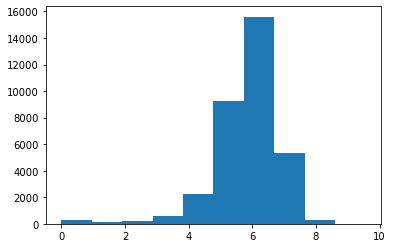

In [35]:
plt.hist(y)
plt.show()

In [36]:
# quantile normalise
y = quantile_gaussianize(y)

In [37]:
# cells by MOFA factors (20)
C_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/mofa_logcounts_model_factors.csv"
C = pd.read_csv(C_file, index_col = 0)
C = xr.DataArray(C.values, dims=["cell", "pc"], coords={"cell": C.index.values, "pc": C.columns.values})
C = C.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(C.cell.values == sample_mapping["phenotype_sample_id"].values)

In [38]:
# quantile normalise cell contexts
C_gauss = quantile_gaussianize(C)

In [39]:
n_cells = phenotype.shape[1]
W = ones((n_cells, 1))

In [40]:
y = y.values.reshape(y.shape[0],1)
y.shape

(33964, 1)

In [41]:
start_time = time.time()
GG = G_expanded.values
print("--- %s seconds ---" % (time.time() - start_time))

--- 240.81879377365112 seconds ---


In [42]:
# from typing import Optional

from glimix_core.lmm import LMM
from numpy import (
    asarray,
#     atleast_1d,
#     atleast_2d,
    concatenate,
    inf,
#     linspace,
#     ones,
#     sqrt,
#     stack,
)
# from numpy.linalg import cholesky
from numpy_sugar import ddot
from numpy_sugar.linalg import economic_qs_linear, economic_svd
# from tqdm import tqdm

from cellregmap._math import PMat, QSCov, ScoreStatistic

In [43]:
# get decomposition of K*EEt 
# i.e. get Li's such that K*EEt = L1L1t + L2L2t + ..
# [U, S, _] = economic_svd(C.values[:,0:20])
[U, S, _] = economic_svd(C)
del _
us = U * S
Ls = [ddot(us[:,i], hK_expanded) for i in range(us.shape[1])]
del us

In [44]:
crm = CellRegMap(y=y, W=W, E=C_gauss.values[:,0:10], Ls=Ls)

In [45]:
pv = crm.scan_interaction(G=GG, idx_G = idx_G)[0]
pv

100%|██████████| 10/10 [47:21<00:00, 284.18s/it]


array([0.75490263, 0.75490263, 0.66332932, 0.75490263, 0.2714031 ,
       0.50592643, 0.75917819, 0.50592643, 0.41992576, 0.5493864 ])

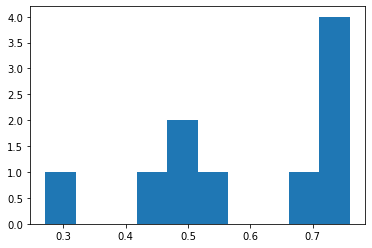

In [46]:
plt.hist(pv)
plt.show()